In [1]:
!pip install --upgrade tensorflow tensorflow_probability

  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import moviepy
import cv2
import math
import tensorflow as tf
from IPython.display import clear_output
import tensorflow_probability as tfp
import time
import random
import gc
from tensorflow.keras import (models, layers)
from sklearn.model_selection import train_test_split

gpu_available = tf.config.list_physical_devices('GPU')

if gpu_available:
    print("GPU is available!")
    # Additional GPU-related information
    gpu_info = !nvidia-smi
    print(gpu_info)
else:
    print("No GPU available. Switch to a GPU runtime in Colab.")

!nvdia-smi

gc.collect()

No GPU available. Switch to a GPU runtime in Colab.
/bin/bash: line 1: nvdia-smi: command not found


0

In [10]:
fps = 20
train_files = range(0, 5)
unlabeled_files = range(5, 10)
frames_number=1200
fps_visual = 30

target_size = (256, 256)

ml_path="/content/drive/MyDrive/Learning/ml/"
root_path = f"{ml_path}/calib"

In [11]:
for x in train_files:
  !wget https://raw.githubusercontent.com/commaai/calib_challenge/main/labeled/{x}.txt -O {x}.txt
  !wget https://raw.githubusercontent.com/commaai/calib_challenge/main/labeled/{x}.hevc -O {x}.hevc

for x in unlabeled_files:
  !wget https://raw.githubusercontent.com/commaai/calib_challenge/main/unlabeled/{x}.hevc -O {x}.hevc

--2024-02-17 02:45:17--  https://raw.githubusercontent.com/commaai/calib_challenge/main/labeled/0.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60000 (59K) [text/plain]
Saving to: ‘0.txt’

0.txt               100%[===================>]  58.59K  --.-KB/s    in 0.01s   

2024-02-17 02:45:17 (4.97 MB/s) - ‘0.txt’ saved [60000/60000]

--2024-02-17 02:45:17--  https://raw.githubusercontent.com/commaai/calib_challenge/main/labeled/0.hevc
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37457546 (36M) [application/octet-stream]
Savi

In [5]:
!ls

df_labels = [
    pd.read_csv(f'{x}.txt', header=None, delimiter=' ')
    for x in train_files
]

x_min = np.min([np.min(df[0]) for df in df_labels ])
x_max = np.max([np.max(df[0]) for df in df_labels ])
y_min = np.min([np.min(df[1]) for df in df_labels ])
y_max = np.max([np.max(df[1]) for df in df_labels ])

print(x_min, x_max, y_min, y_max)

0.hevc	1.hevc	2.hevc	3.hevc	4.hevc	5.hevc	7.hevc	9.hevc
0.txt	1.txt	2.txt	3.txt	4.txt	6.hevc	8.hevc	sample_data
0.0021748560830918773 0.06385971798762553 0.0007007028059796626 0.18212528621029644


In [6]:
def load_labeled_data(frames_index_list, skip_rate = 0):

  def print_reading_status(result, file_index):
    if result["count"] % 10 == 0:
        clear_output(wait=True)

    print("Frames read:", result["count"], f"{file_index}.hevc")

  def load_labeled_data_frame(result, file_index, frames_index_list):
    i = 0
    n = len(df_labels[file_index][0])
    cap = cv2.VideoCapture(f"{file_index}.hevc")

    prev_frame = None

    print("frames_index_list = ", frames_index_list)

    ret = True

    for fi in frames_index_list:


      print_reading_status(result, file_index)

      while fi[0] > i and i < n:
        ret, frame = cap.read()

        if not ret:
          break

        prev_frame = frame

        print_reading_status(result, file_index)

        i += 1

      if not ret:
          break

      while fi[1] >= i and i < n:

        ret, frame = cap.read()

        if not ret:
          break

        if prev_frame is None:
          prev_frame = frame
          i += 1
          continue

        if math.isnan(df_labels[file_index][0][i]):
          i += 1
          continue

        if random.randrange(skip_rate + 1) != 0:
          i += 1
          continue

        print_reading_status(result, file_index)

        result["frames"].append([
          tf.image.resize(prev_frame, target_size),
          tf.image.resize(frame, target_size)
        ])

        prev_frame = frame

        result["index"].append(file_index * 100000 + i)
        result["x"].append(df_labels[file_index][0][i])
        result["y"].append(df_labels[file_index][1][i])

        result["count"] += 1
        i += 1

      if not ret:
          break

    cap.release()

  result = {
      "count": 0,
      "x": [],
      "y": [],
      "frames": [],
      "index": []
  }

  for i in range(len(frames_index_list)):
    load_labeled_data_frame(result, i, frames_index_list[i])

  return result

In [7]:
def prepare_inputs(data):
  tf_frames = tf.stack(data["frames"])

  print(tf_frames.shape)
  input_frame = tf.cast(tf.concat([tf_frames[:, 0, :], tf_frames[:, 1, :]], axis = -1), dtype=tf.float32)

  normalized_batch = input_frame / 255.0

  _, h, w, d =  normalized_batch.shape

  data.update({
      "normalized_batch" : normalized_batch,
      "w" : w,
      "h" : h,
      "d" : d,
      "input_shape": (h, w, d)
  })

  print(data["input_shape"])

def prepare_labels(data):

  labels = np.array(data["x"])

  min = np.min(labels)
  max = np.max(labels)

  print(min, max)

  labels = (labels - x_min) / (x_max - x_min)

  print(np.min(labels), np.max(labels))

  data.update({
      "labels" : labels
  })

  print(data["labels"].shape)

def prepare_shuffled_data(data):

    data_train, data_validation, labels_train, labels_validation = train_test_split(
        data["normalized_batch"].numpy(),
        data["labels"], test_size=0.2, random_state=42)

    data.update({
      "data": data["normalized_batch"],
      "data_train" : data_train,
      "data_validation": data_validation,
      "labels_train": labels_train,
      "labels_validation": labels_validation
    })

    print(data["data_train"].shape)
    print(data["data_validation"].shape)
    print(data["labels_train"].shape)
    print(data["labels_validation"].shape)


def prepare_ml_sets(data):
  print(data.keys())

  prepare_inputs(data)
  prepare_labels(data)
  prepare_shuffled_data(data)

In [8]:
# max data to load - 5013

all_data_frame_indexes = {
    0: [[0, 2000]],
    1: [[0, 2000]],
    2: [[0, 2000]],
    3: [[0, 2000]],
    4: [[0, 2000]]
}

train_data = load_labeled_data({
    0: [[0, 500]],
}, skip_rate = 0)

test_data = load_labeled_data({
    0: [[500, 2000]],
}, skip_rate = 0)



Frames read: 690 0.hevc
Frames read: 691 0.hevc
Frames read: 692 0.hevc
Frames read: 693 0.hevc
Frames read: 694 0.hevc
Frames read: 695 0.hevc
Frames read: 696 0.hevc
Frames read: 697 0.hevc
Frames read: 698 0.hevc
Frames read: 699 0.hevc


In [9]:
prepare_ml_sets(train_data);
prepare_ml_sets(test_data);

dict_keys(['count', 'x', 'y', 'frames', 'index'])
(500, 2, 256, 256, 3)
(256, 256, 6)
0.0323974112529871 0.03509678550822652
0.48995092534484463 0.5337116499682879
(500,)
(400, 256, 256, 6)
(100, 256, 256, 6)
(400,)
(100,)
dict_keys(['count', 'x', 'y', 'frames', 'index'])
(700, 2, 256, 256, 3)
(256, 256, 6)
0.032008734959338724 0.03602203529024461
0.48364992568872306 0.548711274729547
(700,)
(560, 256, 256, 6)
(140, 256, 256, 6)
(560,)
(140,)


1200

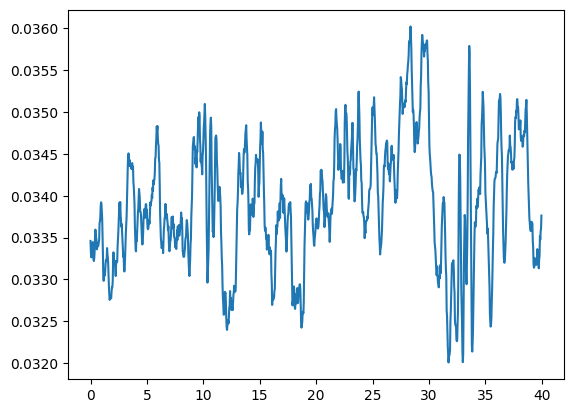

In [ ]:
st = 0
en = 1200
# st = 7*fps_visual
# en = 8*fps_visual

# st = 100
# en = 101

# st=int(0.7 * frames_number)
# st = 0
# en=frames_number


# print(np.arange(40, 200).shape)
# print(df_list[0][0][40:200].shape)
plt.plot(np.arange(st, en)/fps_visual, df_labels[0][0][st:en])
len(df_labels[0][0])

In [ ]:
def get_video_frames(st, en, n):
  cap = cv2.VideoCapture(f"{n}.hevc")
  result = []

  prev_frame = None

  for i in range(st):
    ret, prev_frame = cap.read()

  for i in range(st, en):

    if i % 3 == 0:
      clear_output(wait=True)

    print("Reading frame:", i, f"{n}.hevc")

    ret, frame = cap.read()
    if not ret:
      break

    if prev_frame is not None:
      target_size = (256, 256)

      tf.image.resize(frame, target_size)

      result.append([
        tf.image.resize(prev_frame, target_size),
        tf.image.resize(frame, target_size)
      ])

    prev_frame = frame

  cap.release()

  print()

  return tf.stack(result)

In [ ]:
st = 1
en = 1200

print("before")

# 4 files is limitation

frame_batch = tf.concat([
    get_video_frames(st, en, 0)
    # get_video_frames(st, en, 1),
    # get_video_frames(st, en, 2),
    # get_video_frames(st, en, 3),
    # get_video_frames(st, en, 4),
    # get_video_frames(st, en, 5),
    # get_video_frames(st, en, 6)

], axis=0)

print("after")

# print(frame_batch)

# frame_batch = tf.constant(frame_batch)

print("frame_batch", frame_batch.shape)

# print("frame1", frame_batch[0][0][:3, :3])
# print("frame2", frame_batch[0][1][:3, :3])

input_frame = tf.cast(tf.concat([frame_batch[:, 0, :], frame_batch[:, 1, :]], axis = -1), dtype=tf.float32)

print(input_frame.shape)
# print(input_frame[0][:3].shape)
# print(input_frame[0][:3, :3])
# print(input_frame)

normalized_batch = input_frame / 255.0
# print(input_frame)

_, h,w,d =  normalized_batch.shape

Reading frame: 1197 0.hevc
Reading frame: 1198 0.hevc
Reading frame: 1199 0.hevc

after
frame_batch (1199, 2, 256, 256, 3)
(1199, 256, 256, 6)


0.032008734959338724
0.03602203529024461
0.0
1.0
(1199, 1)


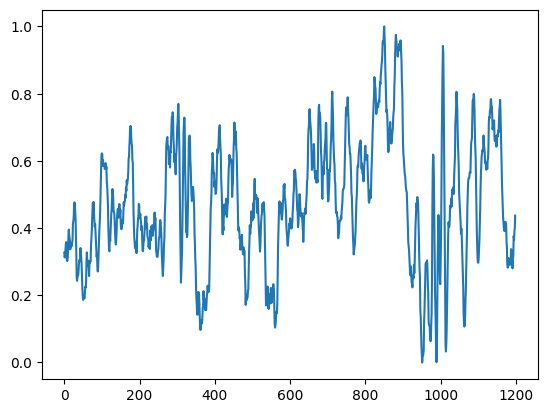

In [ ]:
data = normalized_batch
# labels = df_labels[0][0].to_numpy()[st:en]
labels = df_labels[0][0].to_numpy()[st:en, np.newaxis]

min = np.min(labels)
max = np.max(labels)

print(min)
print(max)



labels = (labels - min) / (max - min)

print(np.min(labels))
print(np.max(labels))

print(labels.shape)

plt.plot(labels)
plt.show()

0.0
1.0
(1199, 1)


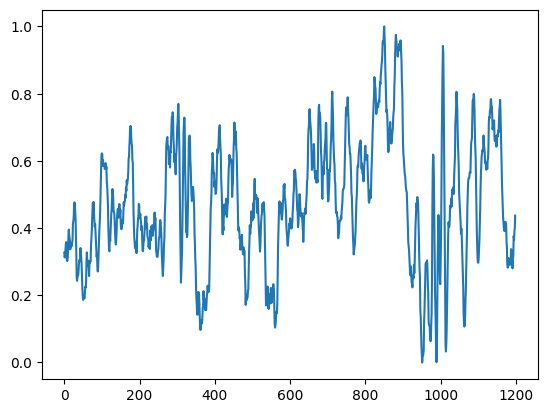

In [ ]:
print(np.min(labels))
print(np.max(labels))

print(labels.shape)

plt.plot(labels)
plt.show()

In [ ]:
print(data.shape)
print(labels.shape)

data_train, data_validation, labels_train, labels_validation = train_test_split(data.numpy()[:600], labels[:600], test_size=0.2, random_state=42)

print()
print("data_train.shape", data_train.shape)
print("data_val.shape", data_validation.shape)
print("labels_train.shape", labels_train.shape)
print("labels_val.shape", labels_validation.shape)

plt.plot(labels_train)
plt.show()

(1199, 256, 256, 6)
(1199, 1)


In [ ]:
print(data.shape)
print(labels.shape)

dataset = tf.data.Dataset.from_tensor_slices((data, labels))

# Get the total size of the dataset
dataset_size = dataset.cardinality().numpy()

print("dataset_size", dataset_size)

fit_ration = 0.5
train_ratio = 0.5

fit_size = int(dataset_size * fit_ration)
train_size = int(fit_size * train_ratio)

print("fit_size", fit_size)
print("train_size", train_size)

fit_dataset = dataset.take(fit_size)
test_dataset = dataset.skip(fit_size).batch(batch_size=32)

# Define the split ratio (e.g., 80% training, 20% validation)

# Shuffle the entire dataset
shuffled_dataset = fit_dataset.shuffle(buffer_size=dataset_size, seed=42)

# Calculate the sizes of training and validation sets

# Split the dataset
train_dataset = shuffled_dataset.take(train_size).batch(batch_size=32)
validation_dataset = shuffled_dataset.skip(train_size).batch(batch_size=32)


print("fit_dataset", tf.data.experimental.cardinality(fit_dataset).numpy())
print("shuffled_dataset", tf.data.experimental.cardinality(fit_dataset).numpy())
print("train_dataset", tf.data.experimental.cardinality(train_dataset).numpy())
print("validation_dataset", tf.data.experimental.cardinality(validation_dataset).numpy())
print("test_dataset", tf.data.experimental.cardinality(test_dataset).numpy())

In [46]:
print(train_data.keys())

dict_keys(['count', 'x', 'y', 'index', 'normalized_batch', 'w', 'h', 'd', 'labels', 'data_train', 'data_validation', 'labels_train', 'labels_validation', 'input_shape'])


In [15]:
def fixed_lr_schedulr(lr):
  def adjust_learning_rate(epoch, current_learning_rate):
    return lr

  return LearningRateScheduler(adjust_learning_rate)

def verify_model(model, data = train_data):
  print("evalutation", model.evaluate(data["data"], data["labels"]))
  predicted = model.predict(data["data"])

  print(predicted.shape)
  print(predicted[:, 0].shape)
  print(predicted[:, 0])

  print("min, max", np.min(predicted), np.max(predicted))

  print("Label X vs X")
  plt.subplot(1, 2, 1)
  plt.plot(labels)
  plt.subplot(1, 2, 2)
  plt.plot(predicted[:, 0])
  plt.show()

  print("Label X vs X")
  plt.plot(labels)
  plt.plot(predicted[:, 0])
  plt.show()

def train_and_verify_model(model, lr = 0.001, epochs=10, batch_size=32):
  # model2.compile(loss='mae', metrics=["mse", "mae"], optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
  history = model.fit(
      train_data["data_train"],
      train_data["labels_train"],
      validation_data=(train_data["data_validation"], train_data["labels_validation"]),
      epochs=epochs,
      batch_size=batch_size,
      callbacks=[fixed_lr_schedulr(lr)]
      )

  clear_output(wait=True)

  plt.plot(history.history["mae"])
  plt.plot(history.history["val_mae"])
  plt.show()

  verify_model(model)

In [ ]:
_,h,w,d =  normalized_batch.shape

def FlowNetS(input_shape=(h, w, 6)):
    model = models.Sequential()

    # Block 1
    model.add(layers.Conv2D(64, (7, 7), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 2
    model.add(layers.Conv2D(128, (5, 5), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 3
    model.add(layers.Conv2D(256, (5, 5), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 4
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 5
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Fully Connected layers
    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))

    # Output layer for optical flow (u, v)
    model.add(layers.Dense(1))

    return model

# Create a FlowNetS model
flownet_model = FlowNetS()

# Display model summary
flownet_model.summary()

# flownet_model.compile(loss='MSE', metrics=["mse", "mae"], optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
flownet_model.compile(loss='mae', metrics=["mse", "mae"], optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

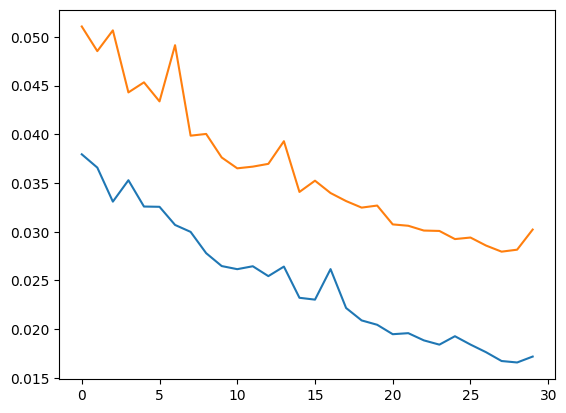

38/38 [==============================] - 3s 77ms/step - loss: 0.0598 - mse: 0.0598 - mae: 0.1332
evalutation [0.059837449342012405, 0.059837449342012405, 0.13324938714504242]
38/38 [==============================] - 3s 74ms/step
(1199, 1)
(1199,)
[0.6457555  0.661223   0.65169835 ... 0.6404617  0.6338388  0.64615864]
min, max 0.10005101 1.013815
Label X vs X


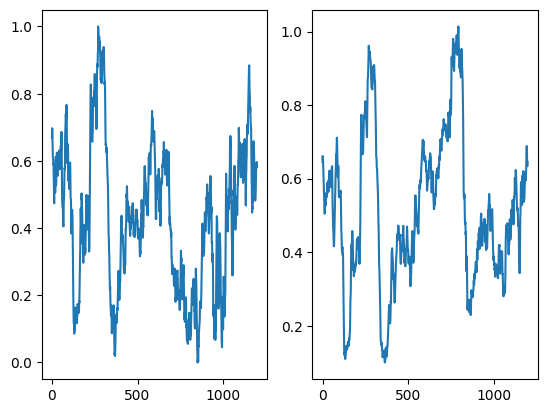

Label X vs X


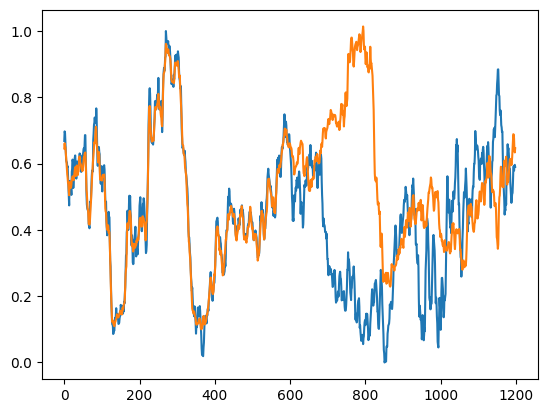

In [ ]:
train_and_verify_model(flownet_model, epochs=30, lr=0.00001)

In [ ]:
input_shape=(h, w, 6)

model2 = models.Sequential()

model2.add(layers.Conv2D(64, (3, 3), activation='tanh', padding='same', input_shape=input_shape))
model2.add(layers.Flatten())
model2.add(layers.Dense(1))

model2.compile(loss='MSE', metrics=['mse', 'mae'], optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 256, 256, 64)      3520      
                                                                 
 flatten_2 (Flatten)         (None, 4194304)           0         
                                                                 
 dense_5 (Dense)             (None, 1)                 4194305   
                                                                 
Total params: 4197825 (16.01 MB)
Trainable params: 4197825 (16.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model3 = models.Sequential()

# Block 1
model3.add(layers.Conv2D(64, (7, 7), activation='relu', padding='same', input_shape=input_shape))
model3.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Block 2
model3.add(layers.Conv2D(128, (5, 5), activation='relu', padding='same'))
model3.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Fully Connected layers
model3.add(layers.Flatten())

# Output layer for optical flow (u, v)
model3.add(layers.Dense(1))

model3.compile(loss='MSE', metrics=['mse', 'mae'], optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

model3.summary()

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_122 (Conv2D)         (None, 256, 256, 64)      18880     
                                                                 
 max_pooling2d_70 (MaxPooli  (None, 128, 128, 64)      0         
 ng2D)                                                           
                                                                 
 conv2d_123 (Conv2D)         (None, 128, 128, 128)     204928    
                                                                 
 max_pooling2d_71 (MaxPooli  (None, 64, 64, 128)       0         
 ng2D)                                                           
                                                                 
 flatten_40 (Flatten)        (None, 524288)            0         
                                                                 
 dense_103 (Dense)           (None, 1)               

In [ ]:
input_shape=(h, w, 6)

model4 = models.Sequential()

model4.add(layers.Flatten(input_shape=input_shape))
model4.add(layers.Dense(4))
model4.add(layers.Dense(4))
model4.add(layers.Dense(1))

model4.compile(loss='mae', metrics=['mse', 'mae'], optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))

model4.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 393216)            0         
                                                                 
 dense_13 (Dense)            (None, 4)                 1572868   
                                                                 
 dense_14 (Dense)            (None, 4)                 20        
                                                                 
 dense_15 (Dense)            (None, 1)                 5         
                                                                 
Total params: 1572893 (6.00 MB)
Trainable params: 1572893 (6.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
input_shape=(h, w, 6)

def new_model():
  model = models.Sequential()

  model.add(layers.Flatten(input_shape=input_shape))
  model.add(layers.Dense(4))
  model.add(layers.Dense(4, activation="relu"))
  model.add(layers.Dense(4, activation="relu"))
  model.add(layers.Dense(4, activation="relu"))
  model.add(layers.Dense(1))

  model.compile(loss='mae', metrics=['mse', 'mae'], optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))

  model.summary()

  return model

model5 = new_model()

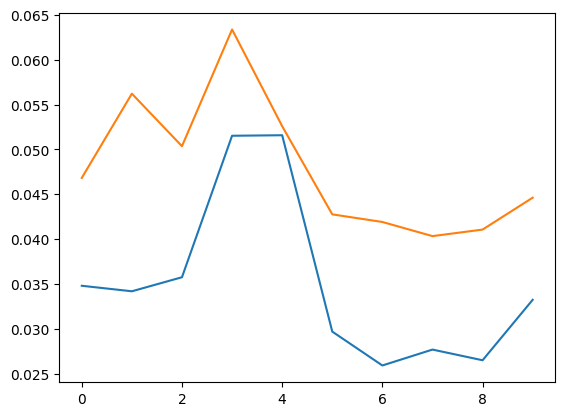

38/38 [==============================] - 2s 47ms/step - loss: 0.1093 - mse: 0.0275 - mae: 0.1093
evalutation [0.10933084040880203, 0.02754494920372963, 0.10933084040880203]
38/38 [==============================] - 1s 36ms/step
(1199, 1)
(1199,)
[0.5992455  0.60975766 0.6072261  ... 0.34444815 0.33127072 0.32110125]
Label X vs X


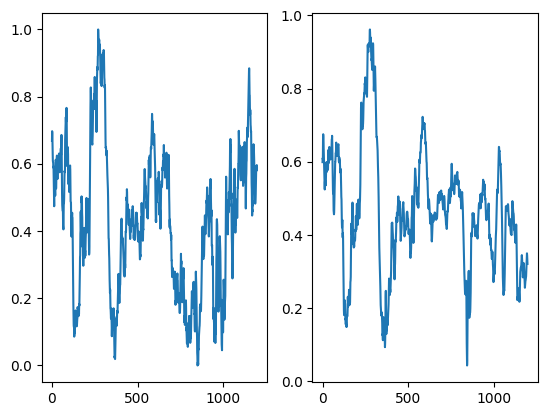

Label X vs X


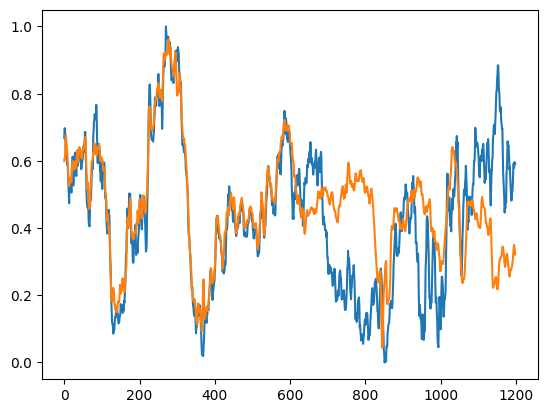

In [ ]:
# model2.compile(loss='mae', metrics=["mse", "mae"], optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
history = model5.fit(data_train, labels_train, validation_data=(data_validation, labels_validation), epochs=10, batch_size=32)

clear_output(wait=True)

plt.plot(history.history["mae"])
plt.plot(history.history["val_mae"])
plt.show()

print("evalutation", model5.evaluate(data, labels))
predicted = model5.predict(data)

print(predicted.shape)
print(predicted[:, 0].shape)
print(predicted[:, 0])

print("Label X vs X")
plt.subplot(1, 2, 1)
plt.plot(labels)
plt.subplot(1, 2, 2)
plt.plot(predicted[:, 0])
plt.show()

print("Label X vs X")
plt.plot(labels)
plt.plot(predicted[:, 0])
plt.show()


In [ ]:
input_shape=(h, w, 6)

def new_model():
  model = models.Sequential()

  model.add(layers.Flatten(input_shape=input_shape))
  model.add(layers.Dense(4))
  model.add(layers.Dense(4, activation="relu"))
  model.add(layers.Dense(4, activation="relu"))
  model.add(layers.Dense(4, activation="relu"))
  model.add(layers.Dense(1))

  model.compile(loss='mae', metrics=['mse', 'mae'], optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))

  model.summary()

  return model

model6 = new_model()

NameError: name 'h' is not defined

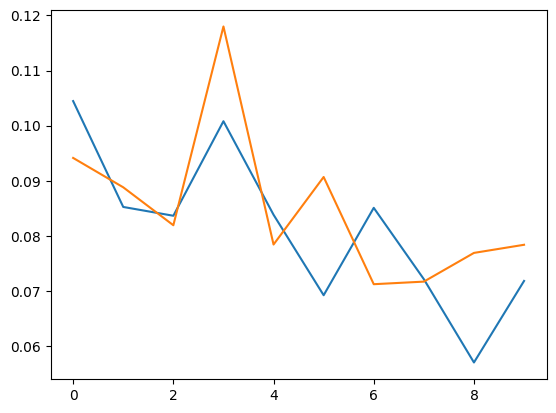

38/38 [==============================] - 2s 49ms/step - loss: 0.1308 - mse: 0.0320 - mae: 0.1308
evalutation [0.13079319894313812, 0.03199709579348564, 0.13079319894313812]
38/38 [==============================] - 2s 43ms/step
(1199, 1)
(1199,)
[0.58900905 0.60525155 0.63920385 ... 0.4601197  0.4320204  0.45438212]
min, max 0.15373842 0.94201934
Label X vs X


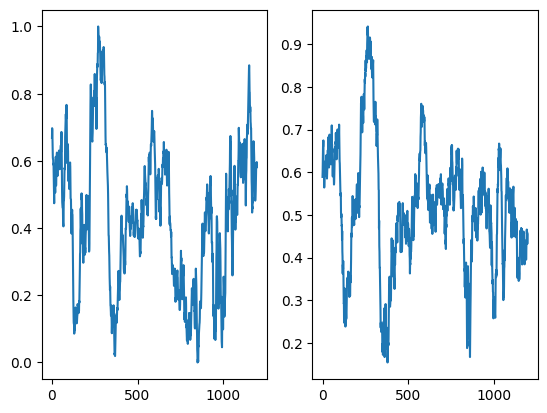

Label X vs X


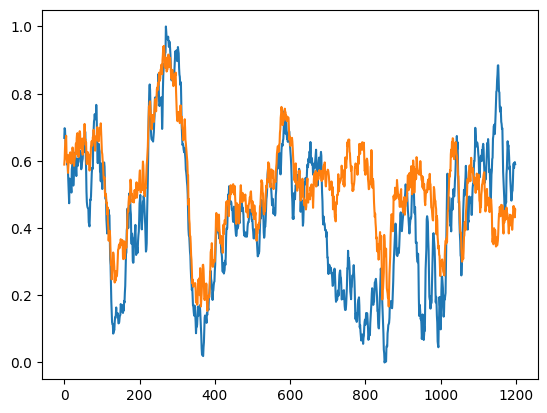

In [ ]:
verify_model(model6, lr=0.00001)

In [ ]:
input_shape=(h, w, 6)

def new_model():
  model = models.Sequential()

  model.add(layers.Flatten(input_shape=input_shape))
  model.add(layers.Dense(4, activation="relu"))
  model.add(layers.Dense(4, activation="relu"))
  model.add(layers.Dense(1))

  model.compile(loss='mae', metrics=['mse', 'mae'], optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))

  model.summary()

  return model

model7 = new_model()

In [ ]:
verify_model(model7, lr=0.00001)

In [ ]:
input_shape=(h, w, 6)

def new_model():
  model = models.Sequential()

  model.add(layers.Flatten(input_shape=input_shape))
  model.add(layers.Dense(1))

  model.compile(loss='mae', metrics=['mse', 'mae'], optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))

  model.summary()

  return model

model7 = new_model()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_32 (Flatten)        (None, 393216)            0         
                                                                 
 dense_123 (Dense)           (None, 1)                 393217    
                                                                 
Total params: 393217 (1.50 MB)
Trainable params: 393217 (1.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


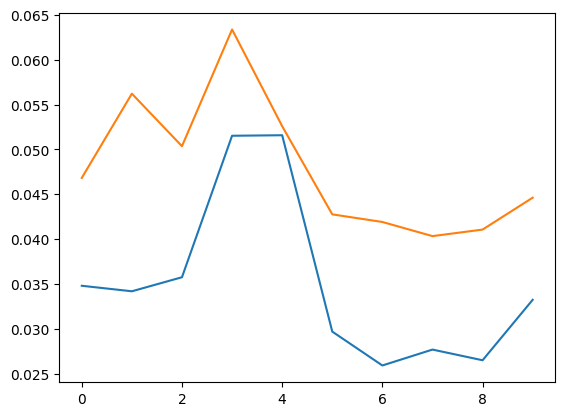

38/38 [==============================] - 1s 37ms/step - loss: 0.1245 - mse: 0.0308 - mae: 0.1245
evalutation [0.12446274608373642, 0.030823608860373497, 0.12446274608373642]
38/38 [==============================] - 2s 55ms/step
(1199, 1)
(1199,)
[0.4645166  0.5159693  0.5571553  ... 0.33979636 0.38600725 0.3186242 ]
min, max 0.008944068 0.8677762
Label X vs X


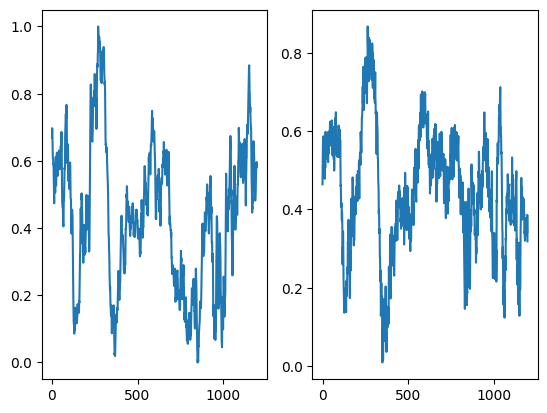

Label X vs X


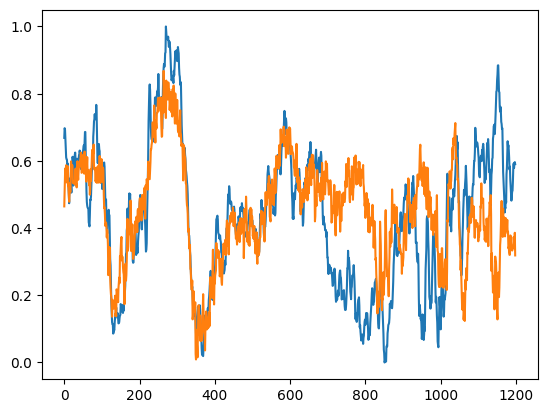

In [ ]:
verify_model(model7)

train_and_verify_model(model7, lr=0.00001)

In [ ]:
input_shape=(h, w, 6)

def new_model():
  model = models.Sequential()

  model.add(layers.Conv2D(64, (7, 7), activation='relu', padding='same', input_shape=input_shape))
  model.add(layers.Flatten(input_shape=input_shape))
  model.add(layers.Dense(1))

  model.compile(loss='mae', metrics=['mse', 'mae'], optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))

  model.summary()

  return model

model8 = new_model()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 256, 256, 64)      18880     
                                                                 
 flatten_33 (Flatten)        (None, 4194304)           0         
                                                                 
 dense_124 (Dense)           (None, 1)                 4194305   
                                                                 
Total params: 4213185 (16.07 MB)
Trainable params: 4213185 (16.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


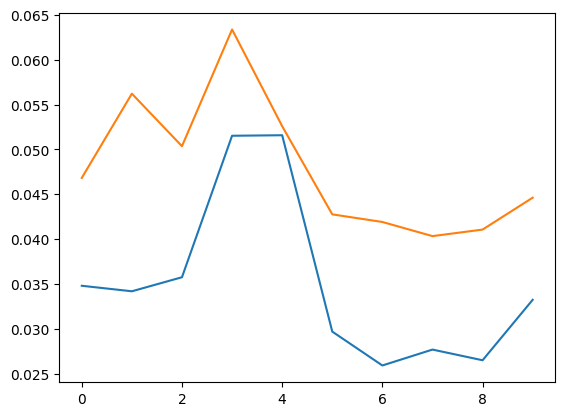

38/38 [==============================] - 2s 46ms/step - loss: 0.1140 - mse: 0.0231 - mae: 0.1140
evalutation [0.11399629712104797, 0.023066062480211258, 0.11399629712104797]
38/38 [==============================] - 2s 44ms/step
(1199, 1)
(1199,)
[0.6189148  0.647581   0.5732043  ... 0.31399515 0.31312725 0.30896172]
min, max -0.021646801 0.93854195
Label X vs X


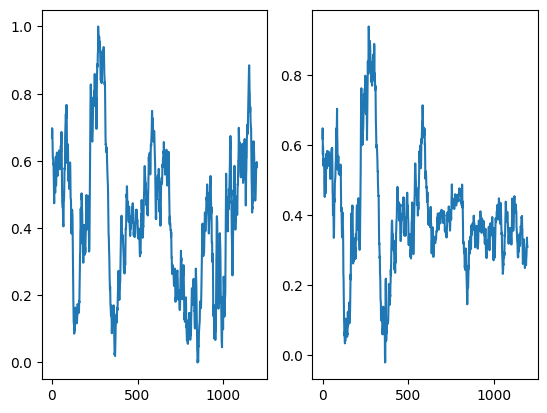

Label X vs X


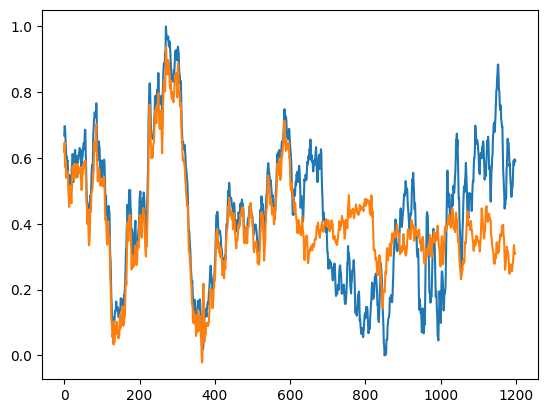

In [ ]:
# verify_model(model7)

train_and_verify_model(model8, lr=0.00001)

In [16]:
input_shape=train_data["input_shape"]

print(input_shape)

def new_model():
  model = models.Sequential()

  model.add(layers.Conv2D(64, (7, 7), activation='relu', padding='same', input_shape=input_shape))
  model.add(layers.Conv2D(64, (7, 7), activation='relu', padding='same', input_shape=input_shape))
  model.add(layers.Conv2D(64, (5, 5), activation='relu', padding='same', input_shape=input_shape))
  model.add(layers.Conv2D(64, (5, 5), activation='relu', padding='same', input_shape=input_shape))
  model.add(layers.Conv2D(64, (2, 2), activation='relu', padding='same', input_shape=input_shape))
  model.add(layers.Conv2D(64, (2, 2), activation='relu', padding='same', input_shape=input_shape))

  model.add(layers.Flatten(input_shape=input_shape))
  model.add(layers.Dense(1))

  model.compile(loss='mae', metrics=['mse', 'mae'], optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))

  model.summary()

  return model

model9 = new_model()

(256, 256, 6)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 64)      18880     
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 64)      200768    
                                                                 
 conv2d_2 (Conv2D)           (None, 256, 256, 64)      102464    
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 64)      102464    
                                                                 
 conv2d_4 (Conv2D)           (None, 256, 256, 64)      16448     
                                                                 
 conv2d_5 (Conv2D)           (None, 256, 256, 64)      16448     
                                                                 
 flatten (Flatten)           (None, 419430

In [ ]:
# verify_model(model7)
verify_model(model9)

train_and_verify_model(model9, lr=0.00001)

 6/16 [==========>...................] - ETA: 6:26 - loss: 0.5131 - mse: 0.2634 - mae: 0.5131